In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv('C:/Users/b01297ar/Documents/ProstateMRL-local/ProstateMRL-Radiomics/Paper1-Release/Output/HM-FS/Features/Features_All.csv')

In [9]:
df = df[df['ContourType'] == 'Manual']
df = df[df['Feature'].isin(['shape_MeshVolume', 'firstorder_Median'])]
df = df[['PatID','Fraction','Feature','FeatureValue']]
df

,PatID,Fraction,Feature,FeatureValue
8,1642,1,shape_MeshVolume,16748.68403
23,1642,1,firstorder_Median,56.00000
115,1642,2,shape_MeshVolume,22840.58241
130,1642,2,firstorder_Median,75.00000
222,1642,3,shape_MeshVolume,21474.71290
...,...,...,...,...
21102,1303,3,firstorder_Median,55.00000
21194,1303,4,shape_MeshVolume,12746.62040
21209,1303,4,firstorder_Median,61.00000
21301,1303,5,shape_MeshVolume,14545.82738


In [10]:
df_signal = df[df['Feature'] == 'firstorder_Median']
df_signal = df_signal[['PatID','Fraction','FeatureValue']]
df_signal = df_signal.rename(columns={'FeatureValue': 'Signal'})

df_volume = df[df['Feature'] == 'shape_MeshVolume']
df_volume = df_volume[['PatID','Fraction','FeatureValue']]
df_volume = df_volume.rename(columns={'FeatureValue': 'Volume'})


In [66]:
patIDs = df['PatID'].unique()
df_signal['Change'] = 0
df_volume['Change'] = 0

# loop over patients and calculate the relative change in feature value to fraction 1
for pat in patIDs:
    df_s = df_signal[df_signal['PatID'] == pat]
    df_v = df_volume[df_volume['PatID'] == pat]

    signals = df_s['Signal'].values
    volumes = df_v['Volume'].values

    # calculate relative change
    sig_ch = (signals - signals[0]) / signals[0]
    vol_ch = (volumes - volumes[0]) / volumes[0]

    # store in dataframe
    df_signal.loc[df_signal['PatID'] == pat, 'Change'] = sig_ch
    df_volume.loc[df_volume['PatID'] == pat, 'Change'] = vol_ch

df_signal['Change'] = df_signal['Change'] + 1
df_volume['Change'] = df_volume['Change'] + 1

df_signal.rename(columns={'Change': 'Signal_Change'}, inplace=True)
df_volume.rename(columns={'Change': 'Volume_Change'}, inplace=True)

In [67]:
df_plot = pd.merge(df_signal, df_volume, on=['PatID', 'Fraction'])

c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  


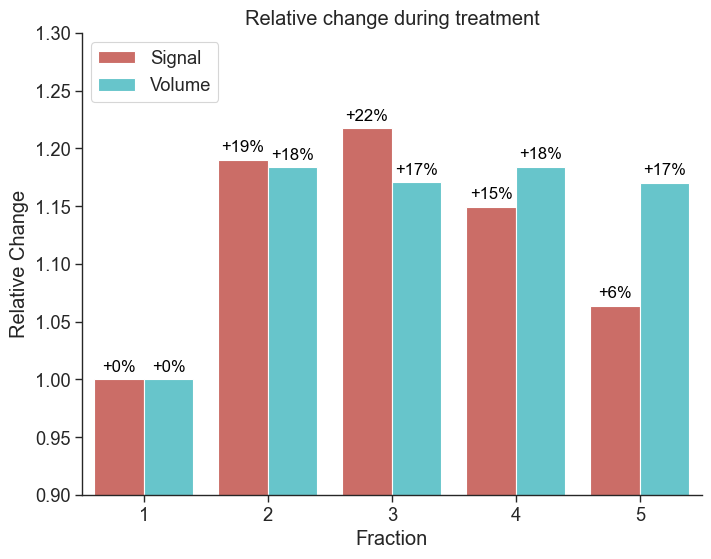

In [69]:
# merge dataframes

df_bplot = df_plot[['PatID','Fraction','Signal_Change','Volume_Change']]
df_bplot = df_bplot.melt(id_vars=['PatID','Fraction'], var_name='Feature', value_name='Change')
df_bplot['Feature'] = df_bplot['Feature'].str.replace('_Change', '')


# plot
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(8, 6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# set no error bars
sns.barplot(x='Fraction', y='Change', hue='Feature', data=df_bplot, ax=ax, errorbar='None', ci=None, estimator=np.median, palette='hls')
ax.set_xlabel('Fraction')
ax.set_ylabel('Relative Change')
ax.set_title('Relative change during treatment')
ax.legend(loc='upper left', )
ax.set_ylim([0.9, 1.3])

# add labels to each bar plot in the graph
for p in ax.patches:
    # set patches on top of bars
    ax.annotate('+' +format((p.get_height() - 1) * 100, '.0f') + '%', 
    (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points',
                fontsize=12, color='black')
                
sns.set_theme(style="ticks", rc=custom_params)
fig.savefig('Plots\BarVolBar.png', dpi=300)

In [62]:
from sklearn.preprocessing import MinMaxScaler 

df_plot = df_plot[['PatID','Fraction','Signal','Volume']]

# scale data
df_plot[['SignalRS']] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_plot[['Signal']])
df_plot[['VolumeRS']] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_plot[['Volume']])


c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\pandas\core\indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is tr

<AxesSubplot:xlabel='Fraction', ylabel='Value'>

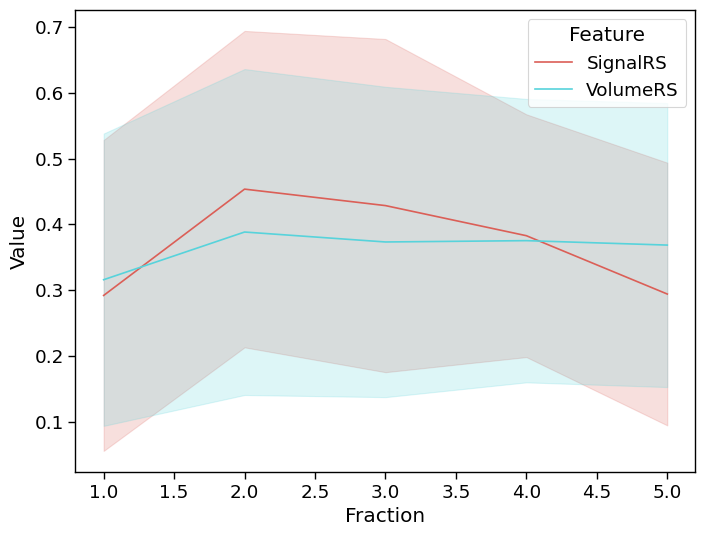

In [64]:
# plot line graph with ci (95%)
df_lplot = df_plot[['PatID','Fraction','SignalRS','VolumeRS']]
df_lplot = df_lplot.melt(id_vars=['PatID','Fraction'], var_name='Feature', value_name='Value')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(8, 6))
# set no error bars
sns.lineplot(x='Fraction', y='Value', hue='Feature', data=df_lplot, ax=ax, estimator=np.mean, palette='hls', errorbar=('sd'))